In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import Lasso
from math import ceil
from scipy.stats import skew
from itertools import product, chain
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

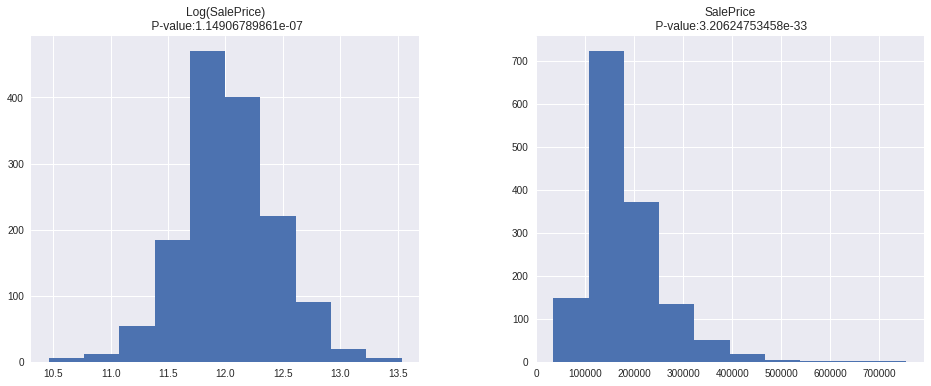

In [3]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train['SalePrice'])[1]
pvalue_after = shapiro(np.log(train['SalePrice']))[1]
graph_data = pd.DataFrame(
    {
        ('SalePrice\n P-value:' + str(pvalue_before)) : train['SalePrice'],
        ('Log(SalePrice)\n P-value:' + str(pvalue_after)) : np.log(train['SalePrice'])
    }
)
graph_data.hist()
plt.show()

In [4]:
train['SalePrice'] = np.log(train['SalePrice'])

In [5]:
data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                 test.loc[:, 'MSSubClass':'SaleCondition']), ignore_index=True)

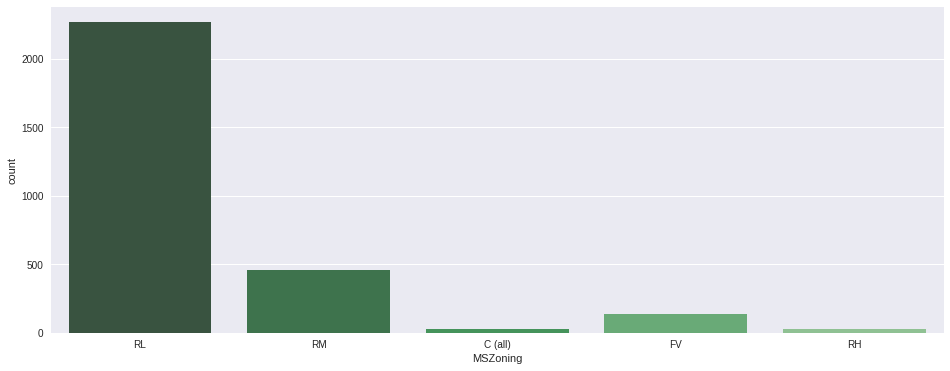

In [6]:
plt.clf()
sns.countplot(x='MSZoning', data=data, palette='Greens_d')
plt.show()

In [7]:
data.loc[data.MSZoning.isnull(), 'MSZoning'] = data.loc[:, 'MSZoning'].mode()[0]

In [8]:
data.loc[:, 'MSZoning'].mode()

0    RL
dtype: object

In [9]:
data.loc[:, 'MSSubClass'].mode()

0    20
dtype: int64

In [10]:
plt.clf()
sns.countplot(x='MSSubClass', data=data, palette='Greens_d')

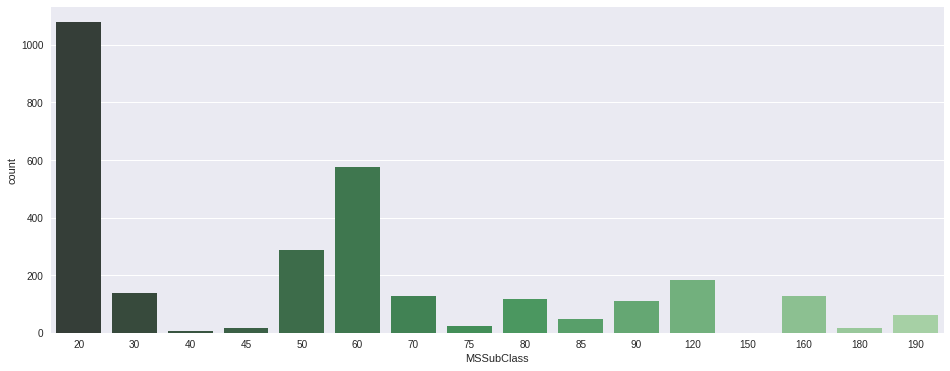

In [11]:
plt.show()

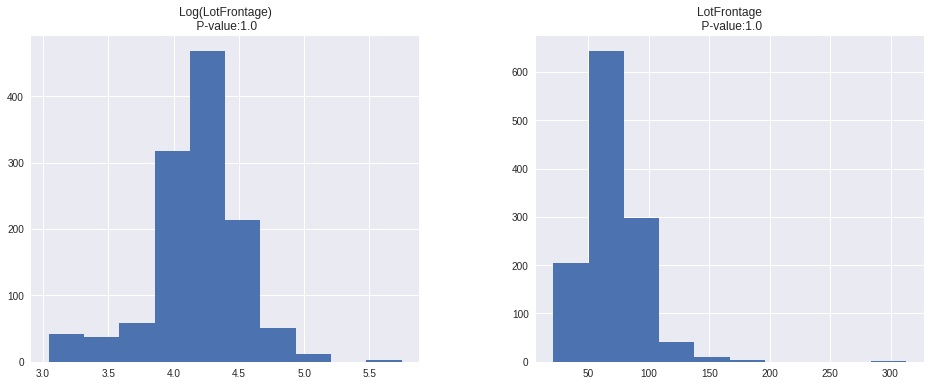

In [12]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train['LotFrontage'])[1]
pvalue_after = shapiro(np.log(train['LotFrontage']))[1]
graph_data = pd.DataFrame(
    {
        ('LotFrontage\n P-value:' + str(pvalue_before)) : train['LotFrontage'],
        ('Log(LotFrontage)\n P-value:' + str(pvalue_after)) : np.log(train['LotFrontage'])
    }
)
graph_data.hist()
plt.show()

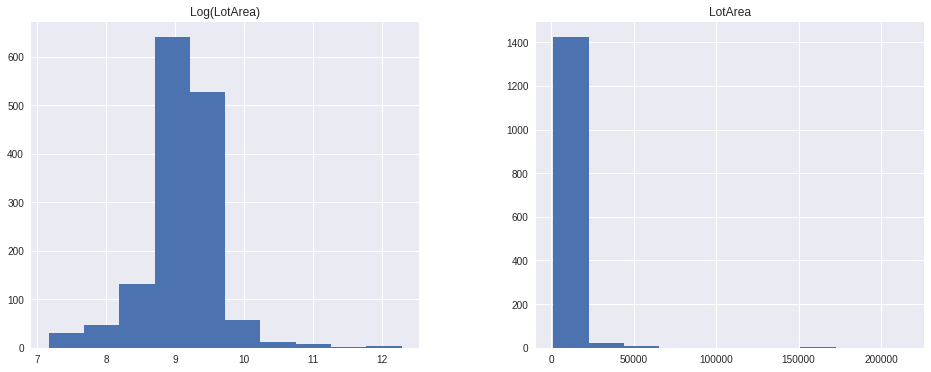

In [13]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
graph_data = pd.DataFrame(
    {
        'LotArea' : train['LotArea'],
        'Log(LotArea)' : np.log(train['LotArea'])
    }
)
graph_data.hist()
plt.show()

In [14]:
x = data.loc[np.logical_not(data['LotFrontage'].isnull()), 'LotArea']
y = data.loc[np.logical_not(data['LotFrontage'].isnull()), 'LotFrontage']

plt.scatter(x, y)

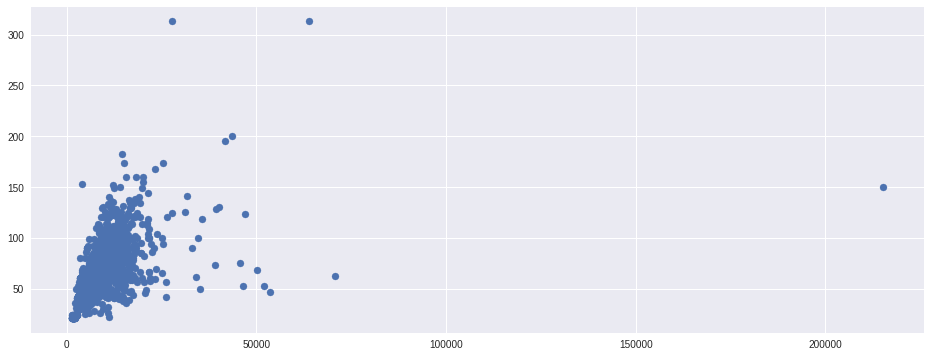

In [15]:
plt.show()

In [16]:
t = (x <= 25000) & (y <= 150)

In [17]:
p = np.polyfit(x[t], y[t], 1)

In [18]:
data.loc[data.LotFrontage.isnull(), 'LotFrontage'] = np.polyval(p, data.loc[data['LotFrontage'].isnull(), 'LotArea'])

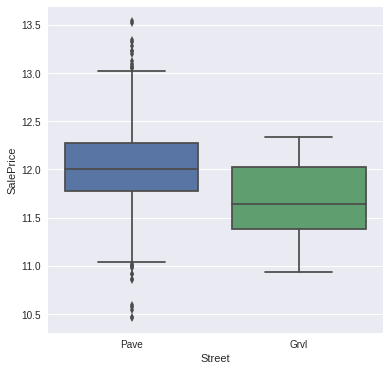

In [19]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.boxplot(x='Street', y='SalePrice', data=train)
plt.show()

In [20]:
data = data.replace(
    {
        'Street': {'Pave': 1, 'Grvl': 0}
    }
)

In [21]:
plt.clf()
sns.countplot(x='Alley', data=data, palette='Greens_d')

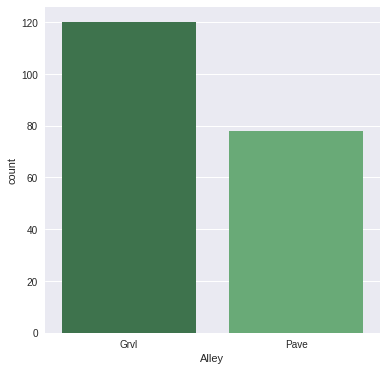

In [22]:
plt.show()

In [23]:
data.loc[data.Alley.isnull(), 'Alley'] = 'NoAlley'

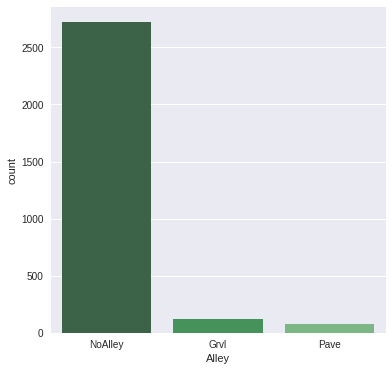

In [24]:
plt.clf()
sns.countplot(x='Alley', data=data, palette='Greens_d')
plt.show()

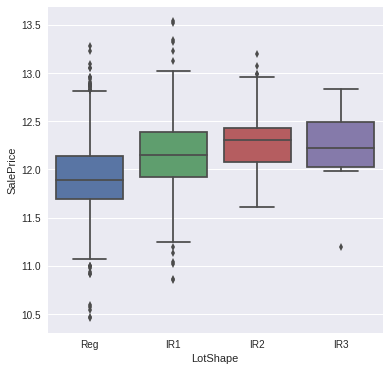

In [25]:
plt.clf()
sns.boxplot(x='LotShape', y='SalePrice', data=train)
plt.show()

In [26]:
plt.clf()
sns.boxplot(x='LandContour', y='SalePrice', data=train)

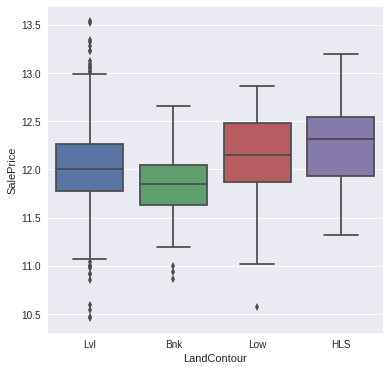

In [27]:
plt.show()

In [28]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
xt = plt.xticks(rotation=45)

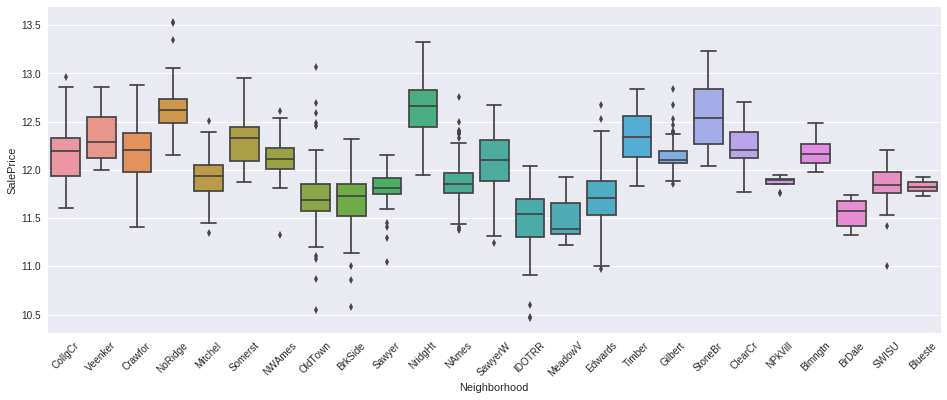

In [29]:
plt.show()

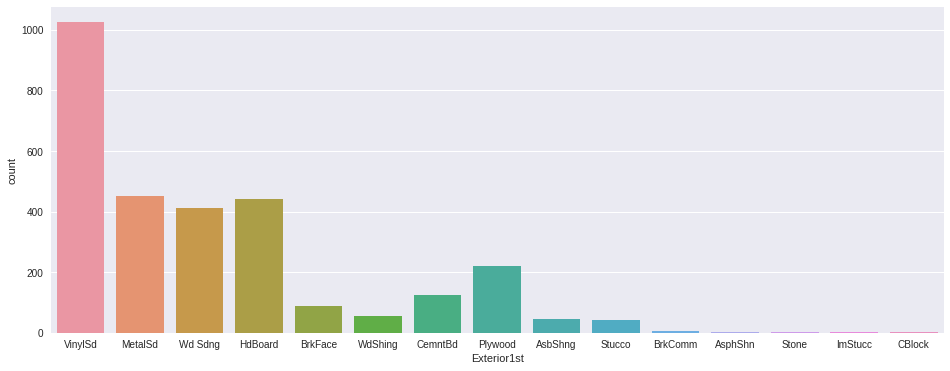

In [30]:
plt.figure(figsize = (16, 6))
sns.countplot(x='Exterior1st', data=data)
plt.show()

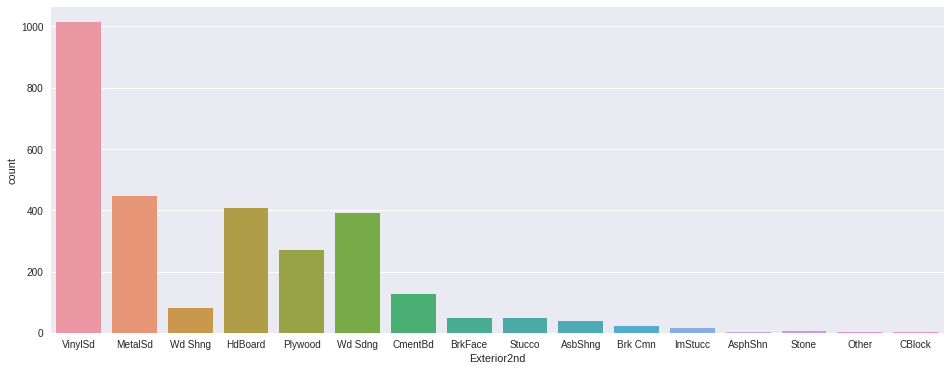

In [31]:
plt.clf()
plt.figure(figsize=(16, 6))
sns.countplot(x='Exterior2nd', data=data)
plt.show()

In [32]:
data.loc[data.Exterior1st.isnull(), 'Exterior1st'] = data.loc[:, 'Exterior1st'].mode()[0]
data.loc[data.Exterior2nd.isnull(), 'Exterior2nd'] = data.loc[:, 'Exterior2nd'].mode()[0]

In [33]:
IsRemodelled = pd.DataFrame(np.zeros((data.shape[0], 1)), columns=['IsRemodelled'])
IsRemodelled[data.YrSold <= data.YearRemodAdd] = 1

IsRemodelled = IsRemodelled.to_sparse()
data['IsRemodelled'] = IsRemodelled

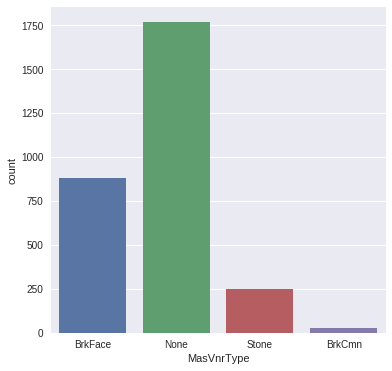

In [34]:
data.loc[data.MasVnrType.isnull(), 'MasVnrType'] = 'None'
plt.figure(figsize=(6, 6))
sns.countplot(x='MasVnrType', data=data)
plt.show()
data.loc[data.MasVnrType == 'None', 'MasVnrArea'] = 0

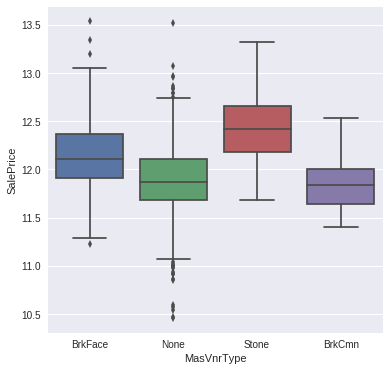

In [35]:
plt.clf()
sns.boxplot(x='MasVnrType', y='SalePrice', data=train)
plt.show()

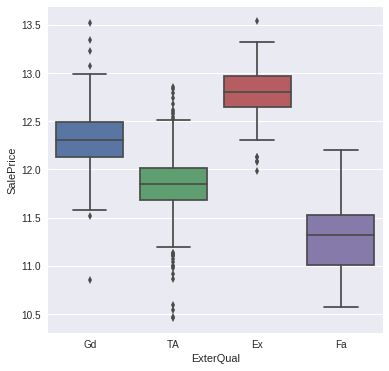

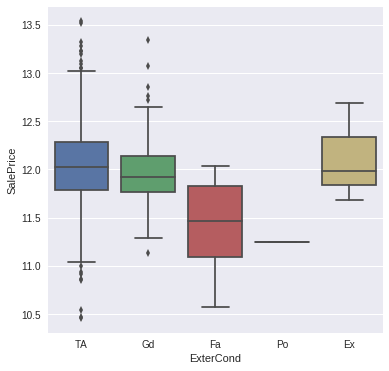

In [36]:
plt.figure(figsize=(6, 6))
sns.boxplot(x='ExterQual', y='SalePrice', data=train)
plt.figure(figsize=(6, 6))
sns.boxplot(x='ExterCond', y='SalePrice', data=train)
plt.show()

In [37]:
data = data.replace(
    {
        'ExterQual': {'Ex': 5,
                      'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                      'Po': 1
        },
        'ExterCond': {'Ex': 5,
                      'Gd': 4,
                      'TA': 3,
                      'Fa': 2,
                      'Po': 1
        }
    }
)

In [38]:
data.loc[data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
data.loc[data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
data.loc[data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
data.loc[data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
data.loc[data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
data.loc[data.BsmtFinType1 == 'NoBsmt', 'BsmtFinSF1'] = 0
data.loc[data.BsmtFinType2 == 'NoBsmt', 'BsmtFinSF2'] = 0
data.loc[data.BsmtQual == 'NoBsmt', 'BsmtUnfSF'] = 0
data.loc[data.BsmtQual == 'NoBsmt', 'TotalBsmtSF'] = 0

In [39]:
data = data.replace({
        'BsmtExposure': {
            'Gd': 3,
            'Av': 2,
            'Mn': 1,
            'No': 0,
            'NoBsmt': 0
        },
        'BsmtCond': {
            'Ex': 5, 
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1,
            'NoBsmt': 0
        }
    })

In [40]:
data = data.replace(
    {
        'HeatingQC': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        },
        'CentralAir': {
            'Y': 1,
            'N': 0
        }
    }
)

data.loc[data.Electrical.isnull(), 'Electrical'] = data.loc[:, 'Electrical'].mode()[0]

data.loc[data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
data.loc[data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0

data.loc[data.KitchenQual.isnull(), 'KitchenQual'] = data.loc[:, 'KitchenQual'].mode()[0]
data = data.replace({
        'KitchenQual': {
            'Ex': 5,
            'Gd': 4,
            'TA': 3,
            'Fa': 2,
            'Po': 1
        }
    })

data.loc[data.Functional.isnull(), 'Functional'] = 'Typ'
data = data.replace({
        'Functional': {
            'Typ': 0,
            'Min1': 1,
            'Min2': 1,
            'Mod': 2,
            'Maj1': 3,
            'Maj2': 4,
            'Sev': 5,
            'Sal': 6
        }
    })
